In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
import joblib
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Paths
CLEAN_DATA_PATH = "../data/processed/diabetes_clean.csv"
MODELS_PATH = "../models/model"

In [15]:
# Load clean dataset
def load_clean_data(path=CLEAN_DATA_PATH):
    """
    Membaca dataset hasil preprocessing.
    """
    df = pd.read_csv(path)
    print("Dataset bersih berhasil dimuat.")
    return df

df = load_clean_data()

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

Dataset bersih berhasil dimuat.


In [16]:
# Train-Test Split Untuk Evaluasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
# Load semua model dari folder models
def load_models(models_path=MODELS_PATH):
    """
    Memuat seluruh model .joblib dari folder models.
    """
    model_files = [f for f in os.listdir(models_path) if f.endswith(".joblib")]
    models = {}
    
    for f in model_files:
        name = f.replace(".joblib", "").replace("_", " ")
        models[name] = joblib.load(os.path.join(models_path, f))
    
    print(f"{len(models)} model berhasil dimuat.")
    return models

models = load_models()

3 model berhasil dimuat.


In [18]:
# Fungsi evaluate_model
def evaluate_model(model, X_test, y_test):
    """
    Menghitung metrik evaluasi:
    - Accuracy
    - Precision
    - Recall
    - F1
    - AUC
    - Confusion Matrix
    """
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }
    return metrics

In [19]:
# Fungsi plotting Confussion Matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["No Diabetes", "Diabetes"],
        yticklabels=["No Diabetes", "Diabetes"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [20]:
# Fungsi plotting ROC
def plot_roc_curve(model, X_test, y_test, title="ROC Curve"):
    y_prob = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else model.predict(X_test)
    )

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

In [21]:
# 5-Fold Stratified Cross Validation
print("\n===== 5-Fold Stratified Cross Validation =====")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    print(f"{name}: Mean Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")


===== 5-Fold Stratified Cross Validation =====
Decision Tree: Mean Accuracy = 0.7082 ± 0.0546
KNN: Mean Accuracy = 0.7526 ± 0.0216
XGBoost: Mean Accuracy = 0.7747 ± 0.0227



===== Evaluasi Model di Test Set =====

Decision Tree Metrics:


,Accuracy,Precision,Recall,F1,AUC
0,0.7532,0.6905,0.537,0.6042,0.808


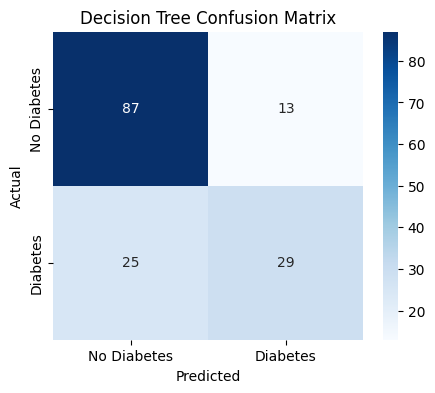

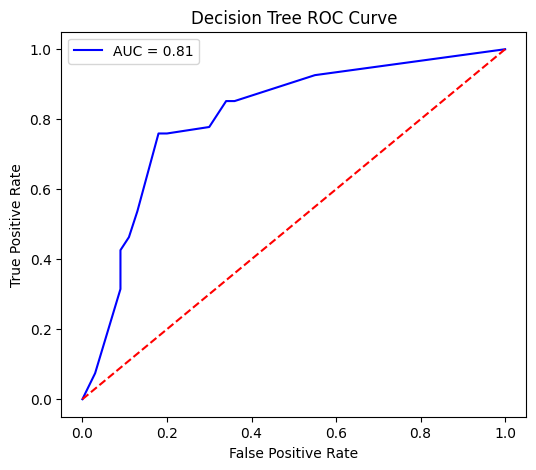


KNN Metrics:


,Accuracy,Precision,Recall,F1,AUC
0,0.7403,0.6346,0.6111,0.6226,0.7951


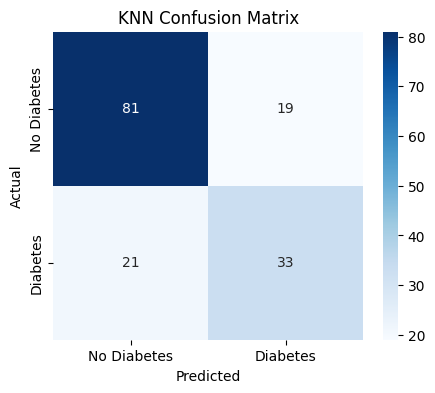

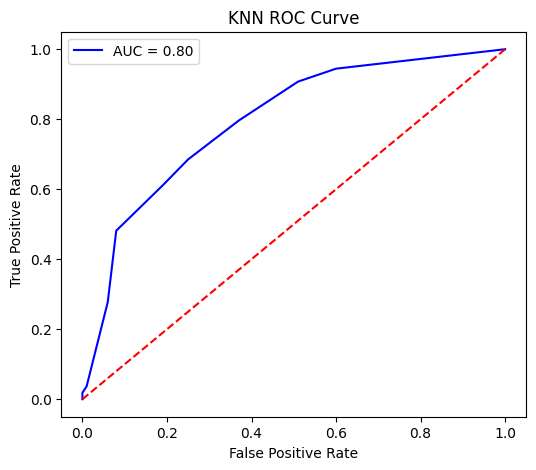


XGBoost Metrics:


,Accuracy,Precision,Recall,F1,AUC
0,0.7532,0.6818,0.5556,0.6122,0.8215


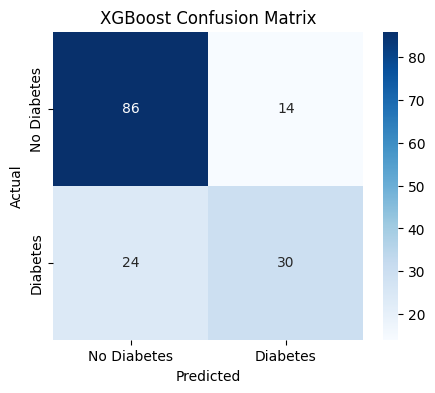

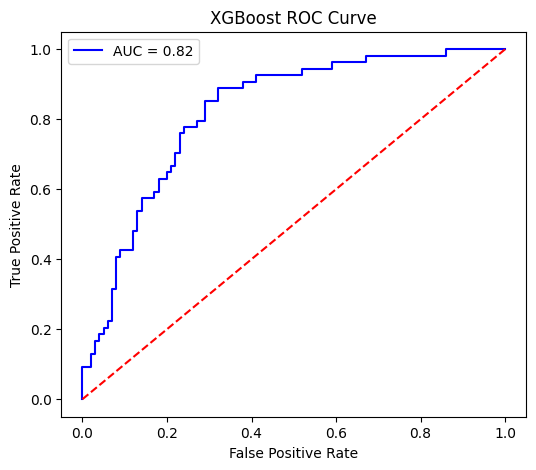

In [22]:
# Evaluasi tiap model di test set
print("\n===== Evaluasi Model di Test Set =====")

for name, model in models.items():
    metrics = evaluate_model(model, X_test, y_test)

    print(f"\n{name} Metrics:")
    metrics_df = pd.DataFrame({
        k: [v] for k, v in metrics.items() if k != "Confusion Matrix"
    }).round(4)

    display(metrics_df)

    # Confusion Matrix
    plot_confusion_matrix(metrics["Confusion Matrix"], title=f"{name} Confusion Matrix")

    # ROC Curve
    plot_roc_curve(model, X_test, y_test, title=f"{name} ROC Curve")